# Figure 5B, 5D and 5E

The code is takes a long time to run. 
The figures can be reproduced direclty (without running all the notebook) by running the section 'Heatmaps'. 


## Import packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import seaborn as sb
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle
plt.rcParams.update({'font.size': 20})

# Definitions

Function to compute the Hill coefficient of a curve z(x) fitting the curve with an Hill function

In [2]:
def model(x, a, b, c):
    return c*x**a/(x**a+b**a) 

def Hill_fit(z,x, bo):
    y= z-min(z)
    yR= y/max(y)
    popt, _ = curve_fit(model, x, yR, bounds=bo)
    a,b,c = popt  
    return [round(a,8), round(b,8), round(c,8)]

Function to plot the heatmap

In [3]:
# My Heatmap
def myHeatmap(data, Min, Max, axs, label): 
    sb.heatmap(data,cmap=mymap,fmt=".4f",vmin=Min, vmax=Max, cbar=True, ax=axs, xticklabels=False, yticklabels=10, cbar_kws={'label': label,"orientation": "horizontal"}, center=0)
    
# Find min and max values of the matrix
def min_array(data):
    min_temp = np.zeros(len(data))
    for i in range(len(data)): 
        min_temp[i]= min(data[i,:])
        
    min_final= min(min_temp)
    return min_final

def max_array(data):
    max_temp = np.zeros(len(data))
    for i in range(len(data)): 
        max_temp[i]= max(data[i,:])
        
    max_final= max(max_temp)
    return max_final

# Model 

Definition of the parameters of the model

In [4]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')

The evolution equation for T

In [5]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [6]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

Definition of the function to compute Erk (as a function of T):

In [7]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

# Results

In [8]:
# Definition of the parameters  
Kb_temp= np.linspace(0.01,1,50)
Kd_temp=  np.linspace(1,2000,50)
Ke_temp=  np.linspace(1,2000,50)
Ks_temp=  np.linspace(1,2000,50)
Krg_temp= np.linspace(1,2000,50)
K2_temp= np.linspace(0.01,1,50)
K1_temp= np.linspace(0.01,1,50)
Vrg_temp= np.linspace(0.01,1,50)
Vs_temp= np.linspace(0.01,1,50)
n_Ftemp = 100
n_Stemp = 100

# Compute S1*: 
S1_star = np.array(solve(-1.1265*S1 +0.9092, S1))
print('S1*=', S1_star[0])

# Define S1_temp: (vector from 0 to S1*)
LogS1star = np.log10(S1_star.astype(float))

S1*= 0.807101642254771


Erk as a function of [FGF], S1 for different values of Vrg¶

In [ ]:
F_temp = np.logspace(-3,6,n_Ftemp) 
n_Vrg_F_fit = np.ones(len(Vrg_temp))
n_Vrg_F_noE_fit = np.ones(len(Vrg_temp))

for kk in range(len(Vrg_temp)): 
    
    T_temp_F = [exprT(F_v =F_temp[i], Vrg_v = Vrg_temp[kk]) for i in range(len(F_temp))]
    T_temp_F_noE = [exprT(F_v =F_temp[i], Vrg_v = Vrg_temp[kk], E_v=0.001) for i in range(len(F_temp))]
    Erk_F = Erk(T_temp_F)
    Erk_F_noE = Erk(T_temp_F_noE)
      
    # Find the Hill coefficients of the curves Erk(FGF) with and without ephrin 
    n_Vrg_F_fit[kk]= Hill_fit(Erk_F, F_temp,bo=((0,0,0),(10,5000,10)))[0]
    n_Vrg_F_noE_fit[kk]= Hill_fit(Erk_F_noE, F_temp,bo=((0,0,0),(10,5000,10)))[0]

In [ ]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp) 
n_Vrg_S1_fit = np.ones(len(Vrg_temp))
n_Vrg_S1_noE_fit = np.ones(len(Vrg_temp))

for kk in range(len(Vrg_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], Vrg_v = Vrg_temp[kk]) for i in range(len(S1_temp))]
    T_temp_S1_noE = [exprT(S1_v =S1_temp[i], Kb_v = Kb_temp[kk], E_v=0.001) for i in range(len(S1_temp))]
    
    Erk_S1 = Erk(T_temp_S1)
    Erk_S1_noE = Erk(T_temp_S1_noE)
       
    # Find the Hill coefficients of the curves Erk(S1) with and without ephrin 
    n_Vrg_S1_fit[kk]= Hill_fit(Erk_S1, S1_temp, bo=((0,0,0),(10,10,10)))[0] # fit
    n_Vrg_S1_noE_fit[kk]= Hill_fit(Erk_S1_noE, S1_temp,bo=((0,0,0),(10,10,10)))[0]

Erk as a function of [FGF], S1 for different values of Kb

In [ ]:
F_temp = np.logspace(-4,5,n_Ftemp) 
n_Kb_F_fit = np.ones(len(Kb_temp))
n_Kb_F_noE_fit = np.ones(len(Kb_temp))

for kk in range(len(Kb_temp)): 
    
    T_temp_F = [exprT(F_v =F_temp[i], Kb_v = Kb_temp[kk]) for i in range(len(F_temp))]
    T_temp_F_noE = [exprT(F_v =F_temp[i], Kb_v = Kb_temp[kk], E_v=0.001) for i in range(len(F_temp))]
    
    Erk_F = Erk(T_temp_F)
    Erk_F_noE = Erk(T_temp_F_noE)
      
    # Find the Hill coefficients of the curves Erk(FGF) with and without ephrin 
    n_Kb_F_fit[kk]= Hill_fit(Erk_F, F_temp,bo=((0,0,0),(10,5000,10)))[0]
    n_Kb_F_noE_fit[kk]= Hill_fit(Erk_F_noE, F_temp,bo=((0,0,0),(10,5000,10)))[0]

In [ ]:
S1_temp= np.logspace(-4,LogS1star[0],n_Stemp)
n_Kb_S1_fit = np.ones(len(Kb_temp))
n_Kb_S1_noE_fit = np.ones(len(Kb_temp))

for kk in range(len(Kb_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], Kb_v = Kb_temp[kk]) for i in range(len(S1_temp))]
    T_temp_S1_noE = [exprT(S1_v =S1_temp[i], Kb_v = Kb_temp[kk], E_v=0.001) for i in range(len(S1_temp))]
    
    Erk_S1 = Erk(T_temp_S1)
    Erk_S1_noE = Erk(T_temp_S1_noE)
    
    # Find the Hill coefficients of the curves Erk(S1) with and without ephrin 
    n_Kb_S1_fit[kk]= Hill_fit(Erk_S1, S1_temp, bo=((0,0,0),(10,10,10)))[0]
    n_Kb_S1_noE_fit[kk]= Hill_fit(Erk_S1_noE, S1_temp, bo=((0,0,0),(10,10,10)))[0]

Erk as a function of [FGF], S1 for different values of Kd

In [ ]:
F_temp = np.logspace(-4,7,n_Ftemp) 
n_Kd_F_fit = np.ones(len(Kd_temp))
n_Kd_F_noE_fit = np.ones(len(Kd_temp))

for kk in range(len(Kd_temp)): 
    
    T_temp_F = [exprT(F_v =F_temp[i], Kd_v = Kd_temp[kk]) for i in range(len(F_temp))]
    T_temp_F_noE = [exprT(F_v =F_temp[i], Kd_v = Kd_temp[kk], E_v=0.001) for i in range(len(F_temp))]
    
    Erk_F = Erk(T_temp_F)
    Erk_F_noE = Erk(T_temp_F_noE)
      
    # Find the Hill coefficients of the curves Erk(FGF) with and without ephrin 
    n_Kd_F_fit[kk]= Hill_fit(Erk_F, F_temp, bo=((0,0,0),(10, 5000,10)) )[0]
    n_Kd_F_noE_fit[kk]= Hill_fit(Erk_F_noE, F_temp, bo=((0,0,0),(10,5000,10)) )[0]

In [ ]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
n_Kd_S1_fit = np.ones(len(Kd_temp))
n_Kd_S1_noE_fit = np.ones(len(Kd_temp))

params =[1,1, 0.1]

for kk in range(len(Kd_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], Kd_v = Kd_temp[kk]) for i in range(len(S1_temp))]
    T_temp_S1_noE = [exprT(S1_v =S1_temp[i], Kd_v = Kd_temp[kk], E_v=0.001) for i in range(len(S1_temp))]
    
    Erk_S1 = Erk(T_temp_S1)
    Erk_S1_noE = Erk(T_temp_S1_noE)
     
    # Find the Hill coefficients of the curves Erk(S1) with and without ephrin 
    n_Kd_S1_fit[kk]= Hill_fit(Erk_S1, S1_temp,bo=((0,0,0),(10,10,10)))[0]
    n_Kd_S1_noE_fit[kk]= Hill_fit(Erk_S1_noE, S1_temp,bo=((0,0,0),(10,10,10)))[0]

Erk as a function of [FGF], S1 for different values of Ke

In [ ]:
F_temp = np.logspace(-3,5,n_Ftemp) 
n_Ke_F_fit = np.ones(len(Ke_temp))
n_Ke_F_noE_fit = np.ones(len(Ke_temp))

for kk in range(len(Ke_temp)): 
    
    T_temp_F = [exprT(F_v =F_temp[i], Ke_v = Ke_temp[kk]) for i in range(len(F_temp))]
    T_temp_F_noE = [exprT(F_v =F_temp[i], Ke_v = Ke_temp[kk], E_v=0.001) for i in range(len(F_temp))]
    
    Erk_F = Erk(T_temp_F)
    Erk_F_noE = Erk(T_temp_F_noE)
       
    # Find the Hill coefficients of the curves Erk(FGF) with and without ephrin 
    n_Ke_F_fit[kk]= Hill_fit(Erk_F, F_temp, bo=((0,0,0),(10,5000,10)) )[0]
    n_Ke_F_noE_fit[kk]= Hill_fit(Erk_F_noE, F_temp, bo=((0,0,0),(10,5000,10)) )[0]

In [ ]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
n_Ke_S1_fit = np.ones(len(Ke_temp))
n_Ke_S1_noE_fit = np.ones(len(Ke_temp))

for kk in range(len(Ke_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], Ke_v = Ke_temp[kk]) for i in range(len(S1_temp))]
    T_temp_S1_noE = [exprT(S1_v =S1_temp[i], Ke_v = Ke_temp[kk], E_v=0.001) for i in range(len(S1_temp))]
    
    Erk_S1 = Erk(T_temp_S1)
    Erk_S1_noE = Erk(T_temp_S1_noE)
         
    # Find the Hill coefficients of the curves Erk(S1) with and without ephrin 
    n_Ke_S1_fit[kk]= Hill_fit(Erk_S1, S1_temp, bo=((0,0,0),(10,10,10)))[0]
    n_Ke_S1_noE_fit[kk]= Hill_fit(Erk_S1_noE, S1_temp, bo=((0,0,0),(10,10,10)))[0]

Erk as a function of [FGF], S1 for different values of K1

In [ ]:
F_temp = np.logspace(-3,4,n_Ftemp)
n_K1_F_fit = np.ones(len(K1_temp))
n_K1_F_noE_fit = np.ones(len(K1_temp))

for kk in range(len(K1_temp)): 
    
    T_temp_F = [exprT(F_v =F_temp[i], K1_v = K1_temp[kk]) for i in range(len(F_temp))]
    T_temp_F_noE = [exprT(F_v =F_temp[i], K1_v = K1_temp[kk], E_v=0.001) for i in range(len(F_temp))]
    
    Erk_F = Erk(T_temp_F)
    Erk_F_noE = Erk(T_temp_F_noE)
     
    # Find the Hill coefficients of the curves Erk(FGF) with and without ephrin 
    n_K1_F_fit[kk]= Hill_fit(Erk_F, F_temp,bo=((0,0,0),(10,5000,10)))[0]
    n_K1_F_noE_fit[kk]= Hill_fit(Erk_F_noE, F_temp,bo=((0,0,0),(10,5000,10)))[0]

In [ ]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
n_K1_S1_fit = np.ones(len(K1_temp))
n_K1_S1_noE_fit = np.ones(len(K1_temp))

for kk in range(len(K1_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], K1_v = K1_temp[kk]) for i in range(len(S1_temp))]
    T_temp_S1_noE = [exprT(S1_v =S1_temp[i], K1_v = K1_temp[kk], E_v=0.001) for i in range(len(S1_temp))]
    
    Erk_S1 = Erk(T_temp_S1)
    Erk_S1_noE = Erk(T_temp_S1_noE)
     
    # Find the Hill coefficients of the curves Erk(S1) with and without ephrin 
    n_K1_S1_fit[kk]= Hill_fit(Erk_S1, S1_temp,bo=((0,0,0),(10,10,10)))[0]
    n_K1_S1_noE_fit[kk]= Hill_fit(Erk_S1_noE, S1_temp,bo=((0,0,0),(10,10,10)))[0]

Erk as a function of [FGF], S1 for different values of K2

In [ ]:
F_temp = np.logspace(-3,4,n_Ftemp)

n_K2_F_fit = np.ones(len(K2_temp))
n_K2_F_noE_fit = np.ones(len(K2_temp))

for kk in range(len(K2_temp)): 
    
    T_temp_F = [exprT(F_v =F_temp[i], K2_v = K2_temp[kk]) for i in range(len(F_temp))]
    T_temp_F_noE = [exprT(F_v =F_temp[i], K2_v = K2_temp[kk], E_v=0.001) for i in range(len(F_temp))]
    
    Erk_F = Erk(T_temp_F)
    Erk_F_noE = Erk(T_temp_F_noE)
     
    # Find the Hill coefficients of the curves Erk(FGF) with and without ephrin 
    n_K2_F_fit[kk]= Hill_fit(Erk_F, F_temp,bo=((0,0,0),(10,5000,10)))[0]
    n_K2_F_noE_fit[kk]= Hill_fit(Erk_F_noE, F_temp,bo=((0,0,0),(10,5000,10)))[0]

In [ ]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)

n_K2_S1_fit = np.ones(len(K2_temp))
n_K2_S1_noE_fit = np.ones(len(K2_temp))

for kk in range(len(K2_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], K2_v = K2_temp[kk]) for i in range(len(S1_temp))]
    T_temp_S1_noE = [exprT(S1_v =S1_temp[i], K2_v = K2_temp[kk], E_v=0.001) for i in range(len(S1_temp))]
    
    Erk_S1 = Erk(T_temp_S1)
    Erk_S1_noE = Erk(T_temp_S1_noE)
         
    # Find the Hill coefficients of the curves Erk(S1) with and without ephrin 
    n_K2_S1_fit[kk]= Hill_fit(Erk_S1, S1_temp,bo=((0,0,0),(10,10,10)))[0]
    n_K2_S1_noE_fit[kk]= Hill_fit(Erk_S1_noE, S1_temp,bo=((0,0,0),(10,10,10)))[0]

Erk as a function of [FGF], S1 for different values of Vs

In [ ]:
F_temp = np.logspace(-3,6,n_Ftemp)
n_Vs_F_fit = np.ones(len(Vs_temp))
n_Vs_F_noE_fit = np.ones(len(Vs_temp))

for kk in range(len(Vs_temp)): 
    
    T_temp_F = [exprT(F_v =F_temp[i], Vs_v = Vs_temp[kk]) for i in range(len(F_temp))]
    T_temp_F_noE = [exprT(F_v =F_temp[i], Vs_v = Vs_temp[kk], E_v=0.001) for i in range(len(F_temp))]
    
    Erk_F = Erk(T_temp_F)
    Erk_F_noE = Erk(T_temp_F_noE)
     
    # Find the Hill coefficients of the curves Erk(FGF) with and without ephrin 
    n_Vs_F_fit[kk]= Hill_fit(Erk_F, F_temp,bo=((0,0,0),(10,5000,10)))[0]
    n_Vs_F_noE_fit[kk]= Hill_fit(Erk_F_noE, F_temp,bo=((0,0,0),(10,5000,10)))[0]

In [ ]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)
n_Vs_S1_fit = np.ones(len(Vs_temp))
n_Vs_S1_noE_fit = np.ones(len(Vs_temp))

for kk in range(len(Vs_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], Vs_v = Vs_temp[kk]) for i in range(len(S1_temp))]
    T_temp_S1_noE = [exprT(S1_v =S1_temp[i], Vs_v = Vs_temp[kk], E_v=0.001) for i in range(len(S1_temp))]
    
    Erk_S1 = Erk(T_temp_S1)
    Erk_S1_noE = Erk(T_temp_S1_noE)
    
    # Find the Hill coefficients of the curves Erk(S1) with and without ephrin 
    n_Vs_S1_fit[kk]= Hill_fit(Erk_S1, S1_temp, bo=((0,0,0),(10,10,10)))[0]
    n_Vs_S1_noE_fit[kk]= Hill_fit(Erk_S1_noE, S1_temp, bo=((0,0,0),(10,10,10)))[0]

Erk as a function of [FGF], S1 for different values of Ks

In [ ]:
F_temp = np.logspace(-6,5,n_Ftemp)

n_Ks_F_fit = np.ones(len(Ks_temp))
n_Ks_F_noE_fit = np.ones(len(Ks_temp))

for kk in range(len(Ks_temp)): 
    
    T_temp_F = [exprT(F_v =F_temp[i], Ks_v = Ks_temp[kk]) for i in range(len(F_temp))]
    T_temp_F_noE = [exprT(F_v =F_temp[i], Ks_v = Ks_temp[kk], E_v=0.001) for i in range(len(F_temp))]
    
    Erk_F = Erk(T_temp_F)
    Erk_F_noE = Erk(T_temp_F_noE)
    
    # Find the Hill coefficients of the curves Erk(FGF) with and without ephrin 
    n_Ks_F_fit[kk]= Hill_fit(Erk_F, F_temp,bo=((0,0,0),(10,5000,10)))[0]
    n_Ks_F_noE_fit[kk]= Hill_fit(Erk_F_noE, F_temp,bo=((0,0,0),(10,5000,10)))[0]

In [ ]:
S1_temp= np.logspace(-6,LogS1star[0],n_Stemp)

n_Ks_S1_fit = np.ones(len(Ks_temp))
n_Ks_S1_noE_fit = np.ones(len(Ks_temp))

for kk in range(len(Ks_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], Ks_v = Ks_temp[kk]) for i in range(len(S1_temp))]
    T_temp_S1_noE = [exprT(S1_v =S1_temp[i], Ks_v = Ks_temp[kk], E_v=0.001) for i in range(len(S1_temp))]
    
    Erk_S1 = Erk(T_temp_S1)
    Erk_S1_noE = Erk(T_temp_S1_noE)
     
    # Find the Hill coefficients of the curves Erk(S1) with and without ephrin 
    n_Ks_S1_fit[kk]= Hill_fit(Erk_S1, S1_temp,bo=((0,0,0),(10,10,10)))[0]
    n_Ks_S1_noE_fit[kk]= Hill_fit(Erk_S1_noE, S1_temp,bo=((0,0,0),(10,10,10)))[0]

Erk as a function of [FGF], S1 for different values of Krg

In [ ]:
F_temp = np.logspace(-3,5,n_Ftemp)

n_Krg_F_fit = np.ones(len(Krg_temp))
n_Krg_F_noE_fit = np.ones(len(Krg_temp))

for kk in range(len(Krg_temp)): 
    
    T_temp_F = [exprT(F_v =F_temp[i], Krg_v = Krg_temp[kk]) for i in range(len(F_temp))]
    T_temp_F_noE = [exprT(F_v =F_temp[i], Krg_v = Krg_temp[kk], E_v=0.001) for i in range(len(F_temp))]
    
    Erk_F = Erk(T_temp_F)
    Erk_F_noE = Erk(T_temp_F_noE)
        
    # Find the Hill coefficients of the curves Erk(FGF) with and without ephrin 
    n_Krg_F_fit[kk]= Hill_fit(Erk_F, F_temp,bo=((0,0,0),(10,5000,10)))[0]
    n_Krg_F_noE_fit[kk]= Hill_fit(Erk_F_noE, F_temp,bo=((0,0,0),(10,5000,10)))[0]

In [ ]:
S1_temp= np.logspace(-3,LogS1star[0],n_Stemp)

n_Krg_S1_fit = np.ones(len(Krg_temp))
n_Krg_S1_noE_fit = np.ones(len(Krg_temp))

for kk in range(len(Krg_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], Krg_v = Krg_temp[kk]) for i in range(len(S1_temp))]
    T_temp_S1_noE = [exprT(S1_v =S1_temp[i], Krg_v = Krg_temp[kk], E_v=0.001) for i in range(len(S1_temp))]
    
    Erk_S1 = Erk(T_temp_S1)
    Erk_S1_noE = Erk(T_temp_S1_noE)
     
    # Find the Hill coefficients of the curves Erk(S1) with and without ephrin 
    n_Krg_S1_fit[kk]= Hill_fit(Erk_S1, S1_temp,bo=((0,0,0),(10,10,10)))[0]
    n_Krg_S1_noE_fit[kk]= Hill_fit(Erk_S1_noE, S1_temp,bo=((0,0,0),(10,10,10)))[0]

In [ ]:
# Compute the difference: n[Erk(S1)] - n[Erk(FGF)]  
diff_Kb = n_Kb_S1_fit - n_Kb_F_fit
diff_Kd = n_Kd_S1_fit - n_Kd_F_fit
diff_Ke = n_Ke_S1_fit - n_Ke_F_fit
diff_Ks = n_Ks_S1_fit - n_Ks_F_fit
diff_Krg = n_Krg_S1_fit - n_Krg_F_fit
diff_K1 = n_K1_S1_fit - n_K1_F_fit
diff_K2 = n_K2_S1_fit - n_K2_F_fit
diff_Vs = n_Vs_S1_fit - n_Vs_F_fit
diff_Vrg = n_Vrg_S1_fit - n_Vrg_F_fit

# Combine all the data in a single array 
data_01_5B= np.stack((diff_Kb, diff_K1, diff_K2, diff_Vs, diff_Vrg) , axis=-1)
data_02000_5B= np.stack((diff_Ks, diff_Krg, diff_Kd, diff_Ke) , axis=-1)

# Save the data in a .txt file 
np.savetxt('results_01_5B.txt', data_01_5B)
np.savetxt('results_02000_5B.txt', data_02000_5B)

In [ ]:
# Compute the difference: n[Erk]eph - n[Erk]noEph  (Erk[S1])
diff_Kb_S1 = n_Kb_S1_fit - n_Kb_S1_noE_fit
diff_Kd_S1 = n_Kd_S1_fit - n_Kd_S1_noE_fit
diff_Ke_S1 = n_Ke_S1_fit - n_Ke_S1_noE_fit
diff_Ks_S1 = n_Ks_S1_fit - n_Ks_S1_noE_fit
diff_Krg_S1 = n_Krg_S1_fit - n_Krg_S1_noE_fit
diff_K1_S1 = n_K1_S1_fit - n_K1_S1_noE_fit
diff_K2_S1 = n_K2_S1_fit - n_K2_S1_noE_fit
diff_Vs_S1 = n_Vs_S1_fit - n_Vs_S1_noE_fit
diff_Vrg_S1 = n_Vrg_S1_fit - n_Vrg_S1_noE_fit

# Combine all the data in a single array 
data_01_5D= np.stack((diff_Kb_S1, diff_K1_S1, diff_K2_S1, diff_Vs_S1, diff_Vrg_S1) , axis=-1)
data_02000_5D= np.stack((diff_Ks_S1, diff_Krg_S1, diff_Kd_S1, diff_Ke_S1) , axis=-1)

# Save the data in a .txt file 
np.savetxt('results_01_5D.txt', data_01_5D)
np.savetxt('results_02000_5D.txt', data_02000_5D)

In [ ]:
# Compute the difference: n[Erk]eph - n[Erk]noEph  (Erk[FGF])
diff_Kb_F = n_Kb_F_fit - n_Kb_F_noE_fit
diff_Kd_F = n_Kd_F_fit - n_Kd_F_noE_fit
diff_Ke_F = n_Ke_F_fit - n_Ke_F_noE_fit
diff_Ks_F = n_Ks_F_fit - n_Ks_F_noE_fit
diff_Krg_F = n_Krg_F_fit - n_Krg_F_noE_fit
diff_K1_F = n_K1_F_fit - n_K1_F_noE_fit
diff_K2_F = n_K2_F_fit - n_K2_F_noE_fit
diff_Vs_F = n_Vs_F_fit - n_Vs_F_noE_fit
diff_Vrg_F = n_Vrg_F_fit - n_Vrg_F_noE_fit

# Combine all the data in a single array 
data_01_5E= np.stack((diff_Kb_F, diff_K1_F, diff_K2_F, diff_Vs_F, diff_Vrg_F) , axis=-1)
data_02000_5E= np.stack((diff_Ks_F, diff_Krg_F, diff_Kd_F, diff_Ke_F) , axis=-1)

# Save the data in a .txt file 
np.savetxt('results_01_5E.txt', data_01_5E)
np.savetxt('results_02000_5E.txt', data_02000_5E)

## Heat maps

In [8]:
# Define the colormap
import matplotlib.colors as mcolors

# sample the colormaps that you want to use. Use 128 from each so we get 256 colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 0.8, 128))
colors2 = plt.cm.Reds(np.linspace(0,1,128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

### Figure 5B

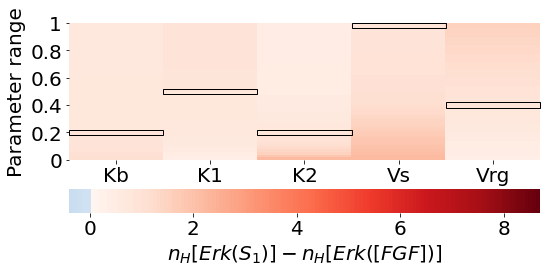

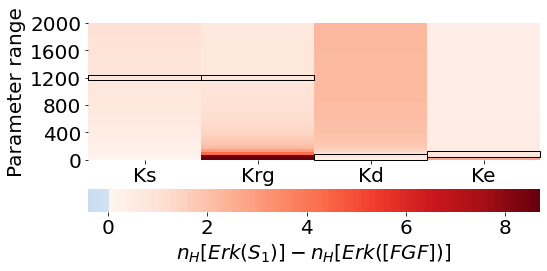

In [9]:
# Load the data 
data_01_5B_load = np.loadtxt('results_01_5B.txt')
data_02000_5B_load = np.loadtxt('results_02000_5B.txt')

# Create the heatmap

# Left panel: Parameters from 0 to 1
Min= -0.4 
Max= max_array(data_02000_5B_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_01_5B_load,Min,Max, axs, label='$n_H[Erk(S_1)]-n_H[Erk([FGF])]$')

axs.add_patch(Rectangle((0, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 24), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((3, 48), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((4, 19), 1, 2, fill=False, edgecolor='black', lw=1,clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5, 4.5])
axs.set_xticklabels(['Kb','K1','K2','Vs', 'Vrg'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','0.2','0.4', '0.6', '0.8', '1'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

# Right panel: Parameters from 0 to 2000
Min= -0.4 
Max= max_array(data_02000_5B_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_02000_5B_load,Min,Max, axs,label='$n_H[Erk(S_1)]-n_H[Erk([FGF])]$')

axs.add_patch(Rectangle((0, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 0), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))
axs.add_patch(Rectangle((3, 1), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5])
axs.set_xticklabels(['Ks','Krg','Kd','Ke'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','400','800', '1200', '1600', '2000'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

### Figure 5D

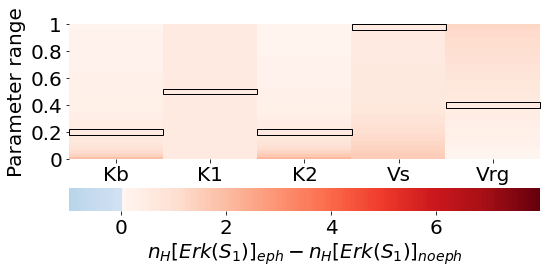

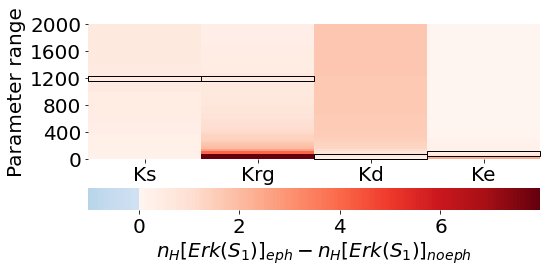

In [10]:
# Load the data 
data_01_5D_load = np.loadtxt('results_01_5D.txt')
data_02000_5D_load = np.loadtxt('results_02000_5D.txt')

# Create the heatmap

# Left panel: Parameters from 0 to 1
Min= - 1 
Max= max_array(data_02000_5D_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_01_5D_load,Min,Max, axs, label='$n_H[Erk(S_1)]_{eph}-n_H[Erk(S_1)]_{no eph}$')

axs.add_patch(Rectangle((0, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 24), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((3, 48), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((4, 19), 1, 2, fill=False, edgecolor='black', lw=1,clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5, 4.5])
axs.set_xticklabels(['Kb','K1','K2','Vs', 'Vrg'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','0.2','0.4', '0.6', '0.8', '1'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

# Rigth panel: Parameters from 0 to 2000
Min= - 1 
Max= max_array(data_02000_5D_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_02000_5D_load,Min,Max, axs,label='$n_H[Erk(S_1)]_{eph}-n_H[Erk(S_1)]_{no eph}$')

axs.add_patch(Rectangle((0, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 0), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))
axs.add_patch(Rectangle((3, 1), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5])
axs.set_xticklabels(['Ks','Krg','Kd','Ke'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','400','800', '1200', '1600', '2000'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

### Figure 5E

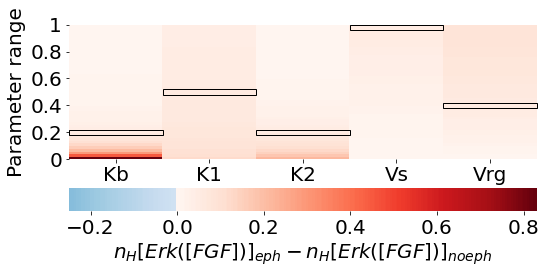

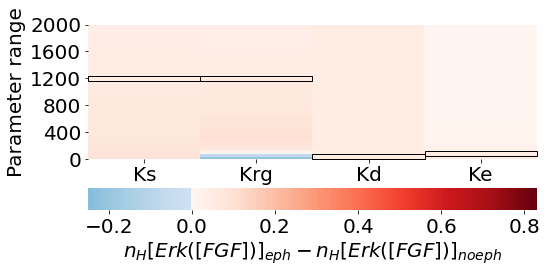

In [11]:
# Load the data 
data_01_5E_load = np.loadtxt('results_01_5E.txt')
data_02000_5E_load = np.loadtxt('results_02000_5E.txt')

# Create the heatmap

# Left panel: Parameters from 0 to 1
Min= - 0.25 
Max= max_array(data_01_5E_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_01_5E_load,Min,Max, axs, label='$n_H[Erk([FGF])]_{eph}-n_H[Erk([FGF])]_{no eph}$')

axs.add_patch(Rectangle((0, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 24), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((3, 48), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((4, 19), 1, 2, fill=False, edgecolor='black', lw=1,clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5, 4.5])
axs.set_xticklabels(['Kb','K1','K2','Vs', 'Vrg'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','0.2','0.4', '0.6', '0.8', '1'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

# Rigth panel: Parameters from 0 to 2000
Min= -0.25 
Max= max_array(data_01_5E_load)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_02000_5E_load,Min,Max, axs,label='$n_H[Erk([FGF])]_{eph}-n_H[Erk([FGF])]_{no eph}$')

axs.add_patch(Rectangle((0, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 0), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))
axs.add_patch(Rectangle((3, 1), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5])
axs.set_xticklabels(['Ks','Krg','Kd','Ke'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','400','800', '1200', '1600', '2000'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()